# CTC HPE Ezmeral Data Fabric Static CSI Demo

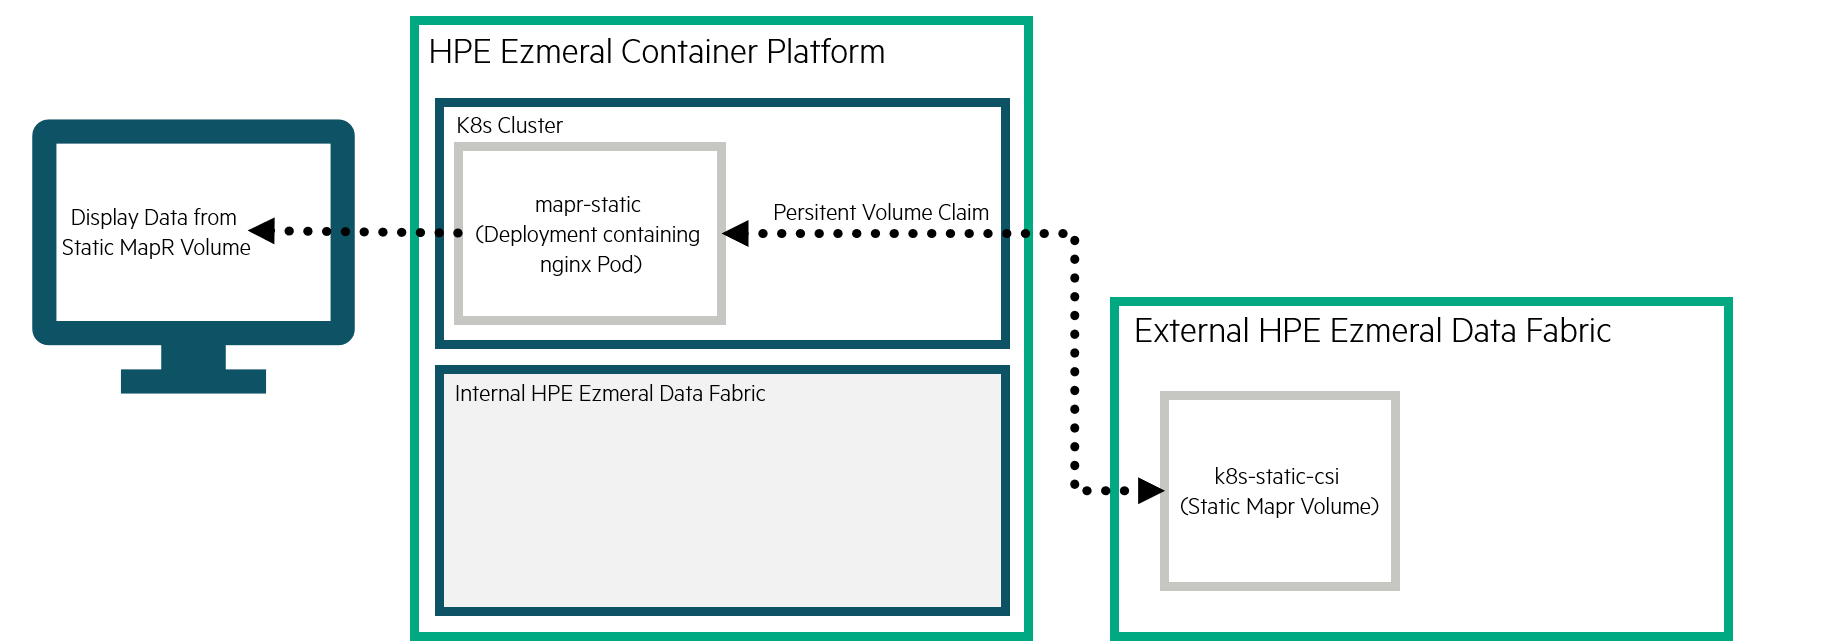

#### Structure of this notebook:

1. Init  
    1.1 Check Environment  
    1.2 Prerequisites
3. Create Persistent Volume and Persistent Volume Claim
4. Create Testing Deployment
5. Create Service Endpoint
6. Clean up

## 1. Init

#### Select the K8s cluster where you are planning the deployment of  dremio

In [19]:
kubectx Development

Switched to context "Development".


#### Select the K8s Namespace / HPECP Tenant where you are planning to provide  access to the static data fabric volume

In [20]:
kubens team1

Context "Development" modified.
Active namespace is "team1".


### 1.1 Check Environment

Check the running pods:

In [ ]:
kubectl get pods

Check the Persitent Volumes:

In [ ]:
kubectl get pv

Check the Persitent Volume Claims:

In [1]:
kubectl get pvc

NAME                                               STATUS   VOLUME                                         CAPACITY   ACCESS MODES   STORAGECLASS       AGE
datadir-cockroachdb-1597666095-0                   Bound    mapr-pv-c9f00772-93f0-4271-8cce-2a4eb721d307   100Gi      RWO            default            31d
datadir-cockroachdb-1597666095-1                   Bound    mapr-pv-7ee59dcc-60d0-452b-82ba-47239fbcbe62   100Gi      RWO            default            31d
datadir-cockroachdb-1597666095-2                   Bound    mapr-pv-443371e5-9cc6-462c-bed3-13c8fafe833d   100Gi      RWO            default            31d
datadir-zk-0                                       Bound    mapr-pv-6dd711dd-247c-46e9-a12a-8a6dd48631c5   10Gi       RWO            default            10d
datadir-zk-1                                       Bound    mapr-pv-60bad4ce-dd58-4e6f-bfdf-5bd27adacc96   10Gi       RWO            default            10d
datadir-zk-2                                       Bound    mapr

Check if the default storage class is: `com.mapr.csi-kdf`

In [ ]:
kubectl get storageclass

### 1.2 Prerequisites External Data Fabric
- Generate MapR Service Ticket on the MapR Node hosting the CLDB (https://mapr.com/docs/61/SecurityGuide/GeneratingServiceTicket.html)  

```
$ maprlogin generateticket -type service -out /tmp/my_longlived_ticket -duration 30:0:0 -renewal 90:0:0 -user mapr  
$ cat /tmp/my_longlived_ticket | base64 --wrap=0
```

- Create Static Volume on the MapR Node hosting the CLDB (name it *k8s-static-csi*)  

```
$ maprcli volume create -name k8s-test-csi -path /k8s-static-csi -type rw
```

- Place an exemplary index.html in the volume

### 1.3 Prerequisites Internal Data Fabric (Demo only) 
This Example is used to show how the whole internal Data Fabric namespace can be exposed using a single mount with the CSI. 
We are using the admin ticket.
```
$ cat /opt/bluedata/mapr/conf/mapruserticket | base64 --wrap=0
```


## 2. Create Persistent Volume and Persistent Volume Claim

Cells below are inspired by: https://mapr.com/docs/61/CSIdriver/csi_example_static_provisioning.html  
Create a Secret. Insert the base64 encoded Service Ticket as value for `CONTAINER_TICKET:`

In [ ]:
cat << 'EOF' | kubectl apply -f -
apiVersion: v1
kind: Secret
metadata:
  name: mapr-ticket-secret
type: Opaque
data:
  CONTAINER_TICKET: aGNwLm1hcHIuY2x1c3RlciBXODY3WEEvd0duRGVRUVNwTUNUQjI2QnBxYm5FdmpTZUFJQnRpYkFIR20yY3NRTUJvWE1ldjFoOWhhNXZhQkhGSk5lM0xpbDZpZG50aWpZQVkxSzQ2aHF5LzA2ZnFhTktQM0xXRVBHWmszNHpCMDVvV1V6ZURyRlRFODFrczhQajBhSkV0MHF4UjZQZ084S1kyVnBQZGFmcUZDckxsR0RQR2dWSUdpMVZqWVlITlpmNlQrakFGM09jMlFtUWx4WTM0RE4wdEI5Znc0NXloREFsQ2VHU1d4cS9xenhtOW5qT25LUnYwVlhPUk9aRURqRVZnOVVRTmZnWDgweEd4Q2VRUHlCYWhTeXNGLzU5N09JZ0Q1Z0JXYUpVL2Q2OFFwZm0rZG9VCg==

Check if the secret was created correctly:

In [25]:
kubectl describe secret mapr-ticket-secret 

Name:         mapr-ticket-secret
Namespace:    team1
Labels:       <none>
Annotations:  
Type:         Opaque

Data
====
CONTAINER_TICKET:  294 bytes


Create a Persistent Volume pointing to the external MapR Cluster. Pay particular attention to the following parameters:  

`volumePath: /VOLUME_PATH
cluster: CLUSTER_NAME
cldbHosts: CLDB_HOSTS`

It is particularly important to define a storage class for the external MapR cluster. Otherwise, the following Persistent Volume Claim takes the standard storage class (internal MapR)!

`storageClassName: external-mapr`

Get CLDB Nodes for external Data Fabric

maprcli node list -columns hostname,ip,csvc  -filter [csvc=="cldb"]

Get CLDB Nodes for internal Data Fabric

- Run the following command on the HPECP Control Node

`bdmapr maprcli node list -columns hostname,ip,csvc  -filter [csvc=="cldb"]`

In [27]:
cat << 'EOF' | kubectl apply -f -
apiVersion: v1
kind: PersistentVolume
metadata:
  name: mapr-static-pv
  namespace: team1
  labels:
    name: mapr-static-pv
spec:
  storageClassName: external-mapr
  accessModes:
  - ReadWriteMany
  persistentVolumeReclaimPolicy: Delete
  capacity:
    storage: 5Gi
  csi:
    nodePublishSecretRef:
      name: "mapr-ticket-secret"
      namespace: team1
    driver: com.mapr.csi-kdf
    volumeHandle: mapr-static-pv
    volumeAttributes:
      volumePath: "/"
      cluster: "hcp.mapr.cluster"
      cldbHosts: "ip-10-1-0-225.eu-west-3.compute.internal"
      securityType: "secure"
      license: "container"
      startupConfig: "-o allow_other -o big_writes -o auto_unmount -o async_dio -o max_background=24 -o auto_inval_data --disable_writeback"
EOF

persistentvolume/mapr-static-pv created


Create a Persistent Volume Claim which uses the same storage class as the Persistent Volume.

`storageClassName: external-mapr`

In [28]:
cat << 'EOF' | kubectl apply -f -
kind: PersistentVolumeClaim
apiVersion: v1
metadata:
  name: mapr-static-pvc
  namespace: team1
spec:
  storageClassName: external-mapr
  accessModes:
    - ReadWriteMany
  resources:
    requests:
      storage: 5Gi
EOF

persistentvolumeclaim/mapr-static-pvc created


In [29]:
kubectl describe pv mapr-static-pv
kubectl describe pvc mapr-static-pvc

Name:            mapr-static-pv
Labels:          name=mapr-static-pv
Annotations:     pv.kubernetes.io/bound-by-controller: yes
Finalizers:      [kubernetes.io/pv-protection]
StorageClass:    external-mapr
Status:          Bound
Claim:           team1/mapr-static-pvc
Reclaim Policy:  Delete
Access Modes:    RWX
VolumeMode:      Filesystem
Capacity:        5Gi
Node Affinity:   <none>
Message:         
Source:
    Type:              CSI (a Container Storage Interface (CSI) volume source)
    Driver:            com.mapr.csi-kdf
    FSType:            
    VolumeHandle:      mapr-static-pv
    ReadOnly:          false
    VolumeAttributes:      cldbHosts=ip-10-1-0-225.eu-west-3.compute.internal
                           cluster=hcp.mapr.cluster
                           license=container
                           securityType=secure
                           startupConfig=-o allow_other -o big_writes -o auto_unmount -o async_dio -o max_background=24 -o auto_inval_data --disable_writeba

## 3. Create Testing Deployment

Create a Testing Deployment which mounts the Persitent Volume over the Claim. 

In [ ]:
cat << 'EOF' | kubectl apply -f -
apiVersion: apps/v1
kind: Deployment
metadata:
  name: mapr-static
  namespace: k8s-demo-tenant
spec:
  selector:
    matchLabels:
      run: mapr-static
  replicas: 1
  template:
    metadata:
      labels:
        run: mapr-static
        hpecp.hpe.com/fsmount: k8s-demo-tenant
    spec:
      containers:
      - name: mapr-static-nginx
        image: nginx:latest
        ports:
        - containerPort: 80
          protocol: TCP
        volumeMounts:
        - name: mapr-static-pv
          mountPath: /usr/share/nginx/html
      volumes:
      - name: mapr-static-pv
        persistentVolumeClaim:
          claimName: mapr-static-pvc
EOF

In [ ]:
kubectl get pods

In [ ]:
kubectl exec -it mapr-static-b78645b74-knh6b -- /bin/sh -c "cat /usr/share/nginx/html/index.html" 

## 4. Create Service Endpoint

In [ ]:
cat << 'EOF' | kubectl apply -f -
apiVersion: v1
kind: Service
metadata:
  name: mapr-static-svc
  labels:
    hpecp.hpe.com/hpecp-internal-gateway: "true"
spec:
  selector: 
    run: mapr-static
  ports:
  - name: mapr-static
    protocol: TCP
    port: 80
    targetPort: 80
  type: NodePort
EOF

Check if service is working and Enpoint is bound to port :80

In [ ]:
kubectl describe service mapr-static-svc

Access : https://hcp50gateway.demo.local:10077
This is where the text of the index.html should be displayed.

## 6. Clean up


Delete the whole demo when you are done

In [ ]:
kubectl delete deployment mapr-static
kubectl delete service mapr-static-svc
kubectl delete pvc mapr-static-pvc
kubectl delete pv mapr-static-pv